# Natural Language Processing –
# **ARABIC FINE-GRAINED DIALECT IDENTIFICATION**



## Installation of required packages

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.5 MB/s 
     |████████████████████████████████| 120 kB 12.4 MB/s 
     |████████████████████████████████| 6.6 MB 44.1 MB/s 


In [ ]:
!pip install camel-tools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 114 kB 8.1 MB/s 
     |████████████████████████████████| 418 kB 50.1 MB/s 
     |████████████████████████████████| 197 kB 53.1 MB/s 
  Created wheel for camel-kenlm: filename=camel_kenlm-2021.12.27-cp37-cp37m-linux_x86_64.whl size=2336408 sha256=a0f6ae041273819b32826afce477648e2e75f0e3bd4356e11f84d7aac3fdae2b
  Stored in directory: /root/.cache/pip/wheels/db/72/74/982f8c435f15b7feaf6dc8a03e212ff34e93f1f2d747059332
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=7c9cf9d9f1278c864de0950104b819a20255a1bdc84a2cf879c1cc94de9f737e
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
  Created wheel for emoji: filename=emoji-2.0.0-py3-none-any.whl size=193022 sha256=9bcb91001968a3943326cac05698a437fb1b6febdadb1b21feef7c9cc59f74be
  Stored in directory: /root/.cac

## **Data preprocessing**

In [ ]:
import pandas as pd
import numpy as np
from transformers import pipeline

In [ ]:
train = pd.read_csv('/content/MADAR-Corpus-6-dev.tsv',sep='.\t', encoding ='utf-8-sig')
train.columns = ["text","Class"]        
train.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,text,Class
0,ما عندكش صرف كتر من هادا,RAB
1,لأ . شارع واحد من هون,BEI
2,هي شنطة زرقة,DOH
3,ابغي ام الربيان نية,DOH
4,يكلفني كام لسياتل,CAI


In [ ]:
# checking for imbalance
train.Class.value_counts()

BEI    1000
DOH    1000
CAI    1000
TUN    1000
MSA    1000
RAB     999
Name: Class, dtype: int64

In [ ]:
import nltk
nltk.download("stopwords")
# arabic stopwords
arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from textblob import TextBlob, Word
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from camel_tools.tokenizers.word import simple_word_tokenize
import re, string

# Pre - processing 

def clean_text(text):
    # lowercasing
    text = text.lower() 
    text = text.strip()  
    # removing xml chars, punctuations, numbers etc.
    text = re.compile('<.*?>').sub('', text)   
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text)
  # Removed @ mentions 
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
  # Removed hashtags
    text = re.sub(r'#', '', text)
  # Removed RT
    text = re.sub(r'RT[\s]+', '', text)
  # Removed hyperlinks
    text = re.sub(r'https?:\/\/\S+', '', text)
    return text

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def tokenization(text):
  filtered_sentence = [] 
  # simple_word_tokenizer from camel tools is used
  word_tokens = simple_word_tokenize(text) 
  filtered_sentence = [w for w in word_tokens if not w in arb_stopwords] 
  return filtered_sentence

# Lemmetize - transform words to its base form
def lemmetize(text):
    inp_text = TextBlob(text)
    text = Word.lemmatize(inp_text)
    return text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# cleaning text
train['text_clean'] = train['text'].apply(clean_text)
# Remove emojis
train['text_clean'] = train['text_clean'].apply(remove_emoji)
# tokenization and stopwords removal
train['text_clean'] = train['text_clean'].apply(tokenization)
# Regenerating text
train['text_clean'] = train['text_clean'].apply(lambda x:' '.join([i+' ' for i in x]))
# Removing double spaces
train['text_clean'] = train['text_clean'].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
# train.head()
# lemmetize the text
train['text_clean'] = train['text_clean'].apply(lemmetize)


In [ ]:
train.head()

,text,Class,text_clean
0,ما عندكش صرف كتر من هادا,RAB,عندكش صرف كتر هادا
1,لأ . شارع واحد من هون,BEI,لأ شارع هون
2,هي شنطة زرقة,DOH,شنطة زرقة
3,ابغي ام الربيان نية,DOH,ابغي ام الربيان نية
4,يكلفني كام لسياتل,CAI,يكلفني كام لسياتل


# **System implementation**

## **1 Feature-Based Classification for Dialectal Arabic**


*   Word-gram features with uni-gram, bi-gram and tri-gram







In [ ]:
from sklearn.model_selection import train_test_split
# Split data in train and test

X_train, X_test, y_train, y_test = train_test_split(train['text_clean'], train['Class'], test_size=0.25, random_state=42)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Word-gram analyzer with n gram range from 1 - 3 
tfidf =  TfidfVectorizer(analyzer = 'word', tokenizer = simple_word_tokenize, ngram_range=(1, 3), stop_words=arb_stopwords) 

X_train_v = tfidf.fit_transform(X_train).toarray()
X_test_v = tfidf.transform(X_test).toarray()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['أفعل', 'أفعله', 'انفك', 'برح', 'سيما'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
X_test_v.shape

(1500, 33969)

In [ ]:
y_train.shape

(4499,)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


# Model training and evaluation

lr = LogisticRegression()

rf = RandomForestClassifier()

nb = GaussianNB()

svc = LinearSVC()

models = [lr , rf, nb, svc]

for x in models:
    x.fit(X_train_v, y_train)
    predictions = x.predict(X_test_v)
    print(str(x))
    print(confusion_matrix(y_true = y_test, y_pred=predictions))
    print(classification_report(y_true = y_test, y_pred=predictions))
    print('Test Accuracy:',  x.score(X_test_v, y_test))

LogisticRegression()
[[151  25  13  32  11  13]
 [  7 165  29  33   3  14]
 [ 22  19 180  26   6   7]
 [  6   4  10 212   5  10]
 [  5  16  12  19 200  15]
 [  6   2  12  11   8 191]]
              precision    recall  f1-score   support

         BEI       0.77      0.62      0.68       245
         CAI       0.71      0.66      0.68       251
         DOH       0.70      0.69      0.70       260
         MSA       0.64      0.86      0.73       247
         RAB       0.86      0.75      0.80       267
         TUN       0.76      0.83      0.80       230

    accuracy                           0.73      1500
   macro avg       0.74      0.73      0.73      1500
weighted avg       0.74      0.73      0.73      1500

Test Accuracy: 0.7326666666666667
RandomForestClassifier()
[[141  13  12  13  51  15]
 [  8 150  32  21  29  11]
 [ 11  20 173  14  32  10]
 [  8   2  13 163  57   4]
 [  5  13  16   6 213  14]
 [  3   4  12   4  30 177]]
              precision    recall  f1-score   suppo


*   Character-gram features with/without word boundary consideration, from bi-gram and
up to 5-gram.



In [ ]:
# char analyzer with word boundary and n gram range from 2 - 5 
tfidf_2 =  TfidfVectorizer(analyzer = 'char', tokenizer = simple_word_tokenize, ngram_range=(2, 5), stop_words=arb_stopwords) 

# convert training data to bag of words
X_train_v2 = tfidf_2.fit_transform(X_train).toarray()
X_test_v2 = tfidf_2.transform(X_test).toarray()

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Model training and results
lr = LogisticRegression()

rf = RandomForestClassifier()

nb = GaussianNB()

svc = LinearSVC()

models = [lr , rf, nb, svc]

for x in models:
    x.fit(X_train_v, y_train)
    predictions = x.predict(X_test_v)
    print(str(x))
    print(confusion_matrix(y_true = y_test, y_pred=predictions))
    print(classification_report(y_true = y_test, y_pred=predictions))
    print('Test Accuracy:',  x.score(X_test_v, y_test))

LogisticRegression()
[[151  25  13  32  11  13]
 [  7 165  29  33   3  14]
 [ 22  19 180  26   6   7]
 [  6   4  10 212   5  10]
 [  5  16  12  19 200  15]
 [  6   2  12  11   8 191]]
              precision    recall  f1-score   support

         BEI       0.77      0.62      0.68       245
         CAI       0.71      0.66      0.68       251
         DOH       0.70      0.69      0.70       260
         MSA       0.64      0.86      0.73       247
         RAB       0.86      0.75      0.80       267
         TUN       0.76      0.83      0.80       230

    accuracy                           0.73      1500
   macro avg       0.74      0.73      0.73      1500
weighted avg       0.74      0.73      0.73      1500

Test Accuracy: 0.7326666666666667
RandomForestClassifier()
[[145  15  15  10  48  12]
 [  6 156  34  21  24  10]
 [ 10  20 168  18  31  13]
 [  5   2  14 164  56   6]
 [  6  11  16   7 211  16]
 [  3   4  13   6  29 175]]
              precision    recall  f1-score   suppo

# **2- LSTM Deep Network**

In [ ]:
!pip install gensim nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# %cd /content
# AraVec 1.0 Twittert-CBOW model
# https://www.dropbox.com/s/ce9phmmawoe1ure/Twt-CBOW.zip?dl=0

!unzip '/content/Twt-CBOW.zip'

Archive:  /content/Twt-CBOW.zip
  inflating: Twt-CBOW                
  inflating: Twt-CBOW.syn1neg.npy    
  inflating: Twt-CBOW.wv.syn0.npy    


In [ ]:
import gensim
w2v = gensim.models.Word2Vec.load('/content/Twt-CBOW')

In [ ]:
# extracting weights
weights_w2v = w2v.wv.vectors
print(weights_w2v.shape)

(164077, 300)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences


In [ ]:
MAX_NB_WORDS = len(w2v.wv.vocab)
EMBEDDING_DIM = 300       
print(len(w2v.wv.vocab))

164077


In [ ]:
# Preparing Data for LSTM model

MAX_SEQUENCE_LENGTH = 200

def w2token(word):
    try:
        return w2v.wv.vocab[word].index
    except KeyError:
        return 0

class DataPrep:
    def __init__(self, dataset, labels, seq_length):
        self.dataset = dataset
        self.labels = labels
        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.categories, self.ccount = np.unique(labels, return_counts=True)
        self.seq_length = seq_length
        self.categories = np.setdiff1d(self.categories, [])
        
    def __iter__(self):
        for text, cat in zip(self.dataset, self.labels):
            text = text.translate(self.translator)
            words = np.array([w2token(w) for w in text.split(' ')[:self.seq_length] if w != ''])           
            yield (words, cat)

# print(train['text_clean'][0])
# print(np.unique(train['Class'], return_counts=True))
sequences = DataPrep(train['text_clean'],train['Class'], MAX_SEQUENCE_LENGTH)

# encoding
cat_dict = {key: val for key, val in zip(sequences.categories, range(len(sequences.categories)))}

x_set = []
y_set = []
for x, y in sequences:
    x_set.append(x)
    y_set.append(cat_dict[y])
    
# Padding sequences 
x_set = pad_sequences(x_set, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
y_set = np.array(y_set)

print(x_set.shape)
print(y_set.shape)


(5999, 200)
(5999,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train_LS, X_test_LS, y_train_LS, y_test_LS = train_test_split(x_set, y_set, test_size=0.25, random_state=42)
print(X_train_LS.shape)
print(y_train_LS.shape)
print(X_test_LS.shape)
print(y_test_LS.shape)

(4499, 200)
(4499,)
(1500, 200)
(1500,)


In [ ]:
import matplotlib.pyplot as plt
# plot function
def Plots(History):
  plt.style.use("ggplot")
  plt.figure()
  plt.title('Loss ')
  plt.plot(History["loss"], label="Train Loss")
  plt.plot( History["val_loss"] ,label = "val Loss")
  plt.ylabel('Loss function')
  plt.xlabel('Epochs')
  plt.legend()
  print("\n")
  plt.figure()
  plt.title('Accuracy')
  plt.plot( History["accuracy"] ,label = "Train Accuracy")
  plt.plot( History["val_accuracy"] ,label = "Val Accuracy")
  plt.ylabel('Accuracy')
  plt.xlabel('Iterations')
  plt.legend()

  # plt.style.use("ggplot")
  plt.figure()
  plt.title('Loss and accuracy')
  plt.plot(History['loss'], label="Train Loss")
  plt.plot(History['val_loss'] ,label = "val Loss")
  plt.plot(History['accuracy'] ,label = "Train Accuracy")
  plt.plot(History['val_accuracy'] ,label = "Val Accuracy")
  plt.xlabel('Epochs')
  plt.legend()



In [ ]:
# Bidirectional LSTM model

n_labels = len(train['Class'].unique())

model = Sequential()

model.add(Embedding(input_dim = MAX_NB_WORDS, output_dim = EMBEDDING_DIM,
                    weights = [weights_w2v], input_length = MAX_SEQUENCE_LENGTH,
                    mask_zero=True, trainable=False))

model.add(Bidirectional(LSTM(100)))

model.add(Dense(n_labels, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_LS, y_train_LS, epochs=5, batch_size=64,
                    validation_data=(X_test_LS, y_test_LS), verbose=1)

Epoch 1/5
71/71 [==============================] - 88s 1s/step - loss: 1.0080 - accuracy: 0.6399 - val_loss: 0.7371 - val_accuracy: 0.7300
Epoch 2/5
71/71 [==============================] - 75s 1s/step - loss: 0.6178 - accuracy: 0.7777 - val_loss: 0.6996 - val_accuracy: 0.7287
Epoch 3/5
71/71 [==============================] - 87s 1s/step - loss: 0.4877 - accuracy: 0.8293 - val_loss: 0.6919 - val_accuracy: 0.7393
Epoch 4/5
71/71 [==============================] - 67s 950ms/step - loss: 0.3958 - accuracy: 0.8655 - val_loss: 0.7098 - val_accuracy: 0.7340
Epoch 5/5
71/71 [==============================] - 65s 920ms/step - loss: 0.3288 - accuracy: 0.8846 - val_loss: 0.7445 - val_accuracy: 0.7453


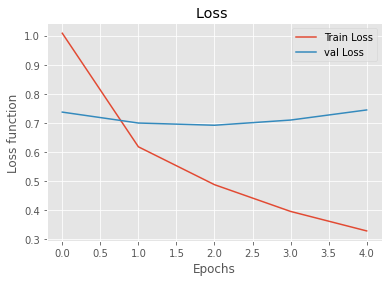

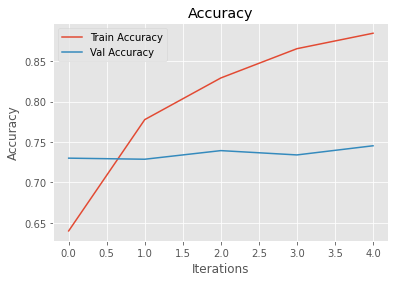

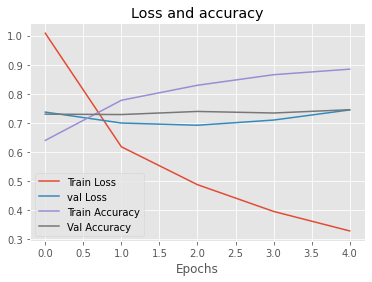

In [ ]:
Plots(history.history)

# **3- BERT for Dialectal Arabic**

arabert model from - https://huggingface.co/aubmindlab/bert-base-arabert

In [ ]:
CUDA_LAUNCH_BLOCKING = 1
import torch

# device = torch.device("cuda:0")
device = 'cpu'

In [ ]:
!pip install pyarabic
!git clone https://github.com/aub-mind/arabert
!pip install farasapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'arabert' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# importing liberaries for arabert
from farasa.segmenter import FarasaSegmenter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score

from transformers import AutoConfig, BertForSequenceClassification, AutoTokenizer
from transformers.data.processors import SingleSentenceClassificationProcessor
from transformers import Trainer , TrainingArguments

In [ ]:
from sklearn.model_selection import train_test_split
from arabert.preprocess import ArabertPreprocessor
# Arabert model
arabic_prep = ArabertPreprocessor('bert-base-arabert')

# preparing data for arabert
train['text_clean'] = train['text'].apply(lambda x: arabic_prep.preprocess(x))

# label encoding
l = train["Class"].value_counts().index.tolist() 
mapping = {x:y for x,y in zip(l, range(len(l)))}
train["Class"] = train["Class"].map(mapping)

# train val split
features = train.drop(['Class'], axis = 1)
train_B, test_B = train_test_split(train, test_size=0.25)


[2022-08-25 21:41:11,957 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [ ]:

# train dataframe
train_df = pd.DataFrame({
    'id':range(len(train_B)),
    'label':train_B["Class"],
    'alpha':['a']*train_B.shape[0],
    'text': train_B["text_clean"].replace(r'\n', ' ', regex=True)
})
# val dataframe
dev_df = pd.DataFrame({
    'id':range(len(test_B)),
    'label':test_B["Class"],
    'alpha':['a']*test_B.shape[0],
    'text': test_B["text_clean"].replace(r'\n', ' ', regex=True)
})

# saving the data
!mkdir data
train_df.to_csv("data/train.tsv",index=False,columns=train_df.columns,sep='\t',header=False)
dev_df.to_csv("data/dev.tsv",index=False,columns=dev_df.columns,sep='\t',header=False)

mkdir: cannot create directory ‘data’: File exists


In [ ]:
model_name = 'aubmindlab/bert-base-arabert' 
num_labels = len(train['Class'].unique())
task_name = 'classification'
max_length = 100

In [ ]:
config = AutoConfig.from_pretrained(model_name,num_labels=num_labels, output_attentions=True) 
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False,  model_max_length=max_length, do_basic_tokenize=True)
model = BertForSequenceClassification.from_pretrained(model_name,config=config)

Some weights of the model checkpoint at aubmindlab/bert-base-arabert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [ ]:
# pre processing data for arabert
train_dataset = SingleSentenceClassificationProcessor(mode='classification')
test_dataset = SingleSentenceClassificationProcessor(mode='classification')

In [ ]:
train_dataset.add_examples(texts_or_text_and_labels=train_df['text'],labels=train_df['label'],overwrite_examples = True)
test_dataset.add_examples(texts_or_text_and_labels=dev_df['text'],labels=dev_df['label'],overwrite_examples = True)

print(train_dataset.examples[0])

InputExample(guid=None, text_a='أي أكتر مكان ترشحهولى في كيوتو أكتر من أي حاج +ة تاني +ة', text_b=None, label=2)


In [ ]:
train_features = train_dataset.get_features(tokenizer = tokenizer, max_length = max_length)
test_features = test_dataset.get_features(tokenizer = tokenizer, max_length = max_length)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
# predefined train arguments function
training_args = TrainingArguments("./train")

In [ ]:
# setting parameters
training_args.do_train = True
training_args.evaluate_during_training = True
training_args.adam_epsilon = 1e-8
training_args.learning_rate = 2e-5
training_args.warmup_steps = 0
training_args.per_gpu_train_batch_size = 16
training_args.per_gpu_eval_batch_size = 16
training_args.num_train_epochs= 5
training_args.logging_steps = (len(train) - 1) // training_args.per_gpu_train_batch_size + 1
training_args.save_steps = training_args.logging_steps 
training_args.seed = 42
#training_args.logging_dir = "gs://" from torch.utils.tensorboard import SummaryWriter supports google cloud storage

In [ ]:
#https://github.com/huggingface/transformers/blob/master/src/transformers/trainer_utils.py
def compute_metrics(p): #p should be of type EvalPrediction
  print(p.predictions)
  preds = np.argmax(p.predictions, axis=0)
  assert len(preds) == len(p.label_ids)
  print(classification_report(p.label_ids,preds))
  print(confusion_matrix(p.label_ids,preds))

  f1_Positive = f1_score(p.label_ids,preds,pos_label=1,average='binary')
  f1_Negative = f1_score(p.label_ids,preds,pos_label=0,average='binary')
  macro_f1 = f1_score(p.label_ids,preds,average='macro')
  macro_precision = precision_score(p.label_ids,preds,average='macro')
  macro_recall = recall_score(p.label_ids,preds,average='macro')
  acc = accuracy_score(p.label_ids,preds)
  return {
      'f1_pos': f1_Positive,
      'f1_neg': f1_Negative,
      'macro_f1' : macro_f1, 
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
  }

In [ ]:
trainer = Trainer(model=model,
                  args = training_args,
                  train_dataset = train_features,
                  eval_dataset = test_features,
                  compute_metrics = compute_metrics)

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.


In [ ]:
# fine tuning pretrained arabert model
trainer.train()

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4499
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1410
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is prefe

Step,Training Loss


Step,Training Loss
375,1.088300
750,0.509400
1125,0.292500


Saving model checkpoint to ./train/checkpoint-375
Configuration saved in ./train/checkpoint-375/config.json
Model weights saved in ./train/checkpoint-375/pytorch_model.bin
Saving model checkpoint to ./train/checkpoint-750
Configuration saved in ./train/checkpoint-750/config.json
Model weights saved in ./train/checkpoint-750/pytorch_model.bin
Saving model checkpoint to ./train/checkpoint-1125
Configuration saved in ./train/checkpoint-1125/config.json
Model weights saved in ./train/checkpoint-1125/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1410, training_loss=0.5403172864981577, metrics={'train_runtime': 14711.4461, 'train_samples_per_second': 1.529, 'train_steps_per_second': 0.096, 'total_flos': 693620596429200.0, 'train_loss': 0.5403172864981577, 'epoch': 5.0})

In [ ]:
import torch
torch.save(model, '/content/arabertModel_finet.bin')

In [ ]:
!zip -r /content/train.zip /content/train

  adding: content/train/ (stored 0%)
  adding: content/train/runs/ (stored 0%)
  adding: content/train/runs/Aug25_21-42-11_f0cf9f000bd2/ (stored 0%)
  adding: content/train/runs/Aug25_21-42-11_f0cf9f000bd2/1661463748.9770088/ (stored 0%)
  adding: content/train/runs/Aug25_21-42-11_f0cf9f000bd2/1661463748.9770088/events.out.tfevents.1661463748.f0cf9f000bd2.702.1 (deflated 63%)
  adding: content/train/runs/Aug25_21-42-11_f0cf9f000bd2/events.out.tfevents.1661463748.f0cf9f000bd2.702.0 (deflated 57%)
  adding: content/train/checkpoint-1125/ (stored 0%)
  adding: content/train/checkpoint-1125/scheduler.pt (deflated 49%)
  adding: content/train/checkpoint-1125/pytorch_model.bin (deflated 7%)
  adding: content/train/checkpoint-1125/config.json (deflated 57%)
  adding: content/train/checkpoint-1125/optimizer.pt (deflated 39%)
  adding: content/train/checkpoint-1125/training_args.bin (deflated 48%)
  adding: content/train/checkpoint-1125/rng_state.pth (deflated 23%)
  adding: content/train/check

In [ ]:
# evaluation of fine tunned arabert model
trainer.evaluate()

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 16
